<a href="https://colab.research.google.com/github/as791/Cat-vs-Dog/blob/master/CatvsDog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
import os
drive.mount('/content/drive',force_remount=True)
os.chdir('/content/drive/My Drive/dogs-vs-cats')

Mounted at /content/drive


In [0]:
os.listdir()

['sampleSubmission.csv',
 'train',
 'test1',
 'X_train.npy',
 'Y_train.npy',
 'nn11.h5',
 'nn21.h5',
 'nn22.h5',
 'nn12.h5',
 'X_test.npy',
 'Y_test.npy']

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm

**Creating Data to Process**

In [0]:
mapping_label = {0:'cat',1:'dog'}

In [0]:
def img_label(img):
  word_label=img.split('.')[0]
  if word_label=='cat':
    return 0
  elif word_label=='dog':
    return 1

In [0]:
def create_train_data(path):
  X,Y=[],[]
  my_dir = os.listdir(path)
  for img in tqdm(my_dir):
    label=img_label(img)
    img_data = cv2.imread('./'+ path +'/'+img, cv2.IMREAD_GRAYSCALE)
    img_data = cv2.resize(img_data, (50, 50))
    X.append(img_data)
    Y.append(label)
  return X,Y

In [0]:
X_train,Y_train=create_train_data('train')

100%|██████████| 25000/25000 [04:55<00:00, 84.64it/s]


In [0]:
X_train  = np.asarray(X_train)
Y_train = np.asarray(Y_train)

In [0]:
np.save('X_train.npy',X_train)
np.save('Y_train.npy',Y_train)

In [0]:
def create_test_data(path):
  X=[]
  my_dir = sorted(list(map(lambda x:int(x[:-4]),os.listdir(path))))
  for img in tqdm(my_dir):
    img_data = cv2.imread('./'+ path +'/'+ str(img) + '.jpg', cv2.IMREAD_GRAYSCALE)
    img_data = cv2.resize(img_data, (50, 50))
    X.append(img_data)
  return X

In [0]:
X_test = create_test_data('test1')

100%|██████████| 12500/12500 [01:41<00:00, 125.97it/s]


In [0]:
X_test = np.asarray(X_test)

In [0]:
X_test.shape

(12500, 50, 50)

In [0]:
np.save('X_test.npy',X_test)

**Loading Data and Preprocessing it and dividing it in test, train, validation set**

In [0]:
X = np.load('X_train.npy')
Y = np.load('Y_train.npy')

In [0]:
X_test = np.load('X_test.npy')

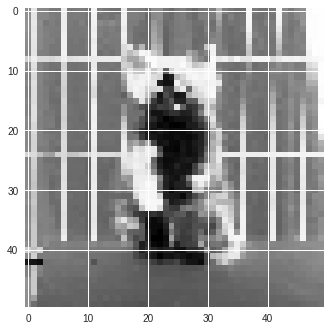

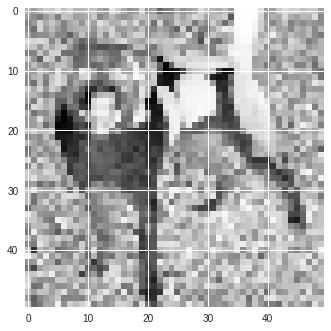

In [0]:
plt.imshow(X[1400])
plt.show()
plt.imshow(X_test[1400])
plt.show()

In [0]:
from keras.utils import to_categorical
Y = to_categorical(Y)

Using TensorFlow backend.


In [0]:
X.shape,Y.shape

((25000, 50, 50), (25000, 2))

In [0]:
X = X.reshape([-1,50,50,1])
X_test = X_test.reshape([-1,50,50,1])

In [0]:
from keras.utils import normalize
X = normalize(X,axis=0)
X_test = normalize(X_test,axis=0)

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
X,Y = shuffle(X,Y,random_state = 2)
X_train,X_val,Y_train,Y_val = train_test_split(X,Y,test_size=0.2,random_state = 2)

In [0]:
X_train.shape,Y_train.shape,X_val.shape,Y_val.shape

((20000, 50, 50, 1), (20000, 2), (5000, 50, 50, 1), (5000, 2))

**Proposed Models and fitting it**

In [0]:
from keras.models import Sequential,Model
from keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten, regularizers, BatchNormalization, AveragePooling2D,Input
import keras.optimizers as optimizers
import keras.callbacks as callbacks
from sklearn import metrics

In [0]:
input_= Input((50,50,1))
conv1  = Conv2D(96,11,padding='same',kernel_regularizer = regularizers.l2(1e-2),activation='relu')(input_)
pool1 = MaxPooling2D((3,3),2)(conv1)
norm1 = BatchNormalization()(pool1)
conv2  = Conv2D(256,5,padding='same',activation='relu')(norm1)
pool2 = MaxPooling2D((3,3),2)(conv2)
norm2 = BatchNormalization()(pool2)
conv3  = Conv2D(384,3,padding='same',activation='relu')(norm2)
conv4  = Conv2D(384,3,padding='same',activation='relu')(conv3)
conv5  = Conv2D(256,3,padding='same',kernel_regularizer = regularizers.l2(1e-2),activation='relu')(conv4)
pool6 = MaxPooling2D((3,3),2)(conv5)
flat7 = Flatten()(pool6)
drop8 = Dropout(0.4)(flat7)
dense9 = Dense(256,kernel_regularizer = regularizers.l2(1e-2),activation='relu')(drop8)
dense10 = Dense(256,activation='relu')(dense9)
dense11 = Dense(2,activation='softmax')(dense10)

model = Model(inputs=input_,outputs=dense11)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 50, 50, 1)         0         
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 50, 50, 96)        11712     
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 24, 24, 96)        0         
_________________________________________________________________
batch_normalization_25 (Batc (None, 24, 24, 96)        384       
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 24, 24, 256)       614656    
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 11, 11, 256)       0         
_________________________________________________________________
batch_normalization_26 (Batc (None, 11, 11, 256)       1024      
__________

In [0]:
sgd = optimizers.SGD(lr = 0.01 ,momentum = 0.9, nesterov = True)
model.compile(optimizer=sgd,loss='binary_crossentropy',metrics=['accuracy'])
lr_reduce = callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=4)

In [0]:
history = model.fit(X_train,Y_train,epochs=20,batch_size=200,validation_data=(X_val,Y_val),callbacks=[lr_reduce])

Train on 20000 samples, validate on 5000 samples
Epoch 1/20
20000/20000 [==============================] - 27s 1ms/step - loss: 7.4495 - acc: 0.6146 - val_loss: 8.7965 - val_acc: 0.4938
Epoch 2/20
20000/20000 [==============================] - 24s 1ms/step - loss: 5.1410 - acc: 0.6874 - val_loss: 5.6028 - val_acc: 0.4938
Epoch 3/20
20000/20000 [==============================] - 24s 1ms/step - loss: 3.5776 - acc: 0.7309 - val_loss: 3.0994 - val_acc: 0.6678
Epoch 4/20
20000/20000 [==============================] - 24s 1ms/step - loss: 2.5290 - acc: 0.7658 - val_loss: 2.1573 - val_acc: 0.7636
Epoch 5/20
20000/20000 [==============================] - 24s 1ms/step - loss: 1.8218 - acc: 0.7901 - val_loss: 1.7887 - val_acc: 0.6900
Epoch 6/20
20000/20000 [==============================] - 24s 1ms/step - loss: 1.3474 - acc: 0.8142 - val_loss: 1.3456 - val_acc: 0.7276
Epoch 7/20
20000/20000 [==============================] - 24s 1ms/step - loss: 1.0233 - acc: 0.8339 - val_loss: 1.2206 - val_acc:

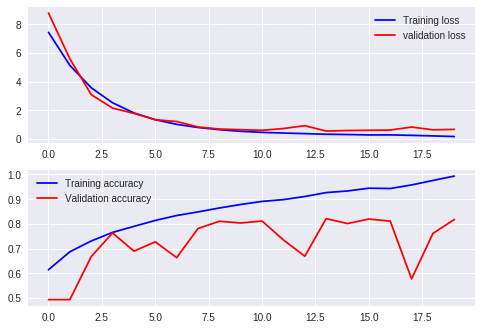

In [0]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [0]:
pred = model.predict(X_val)
Y_pred = np.argmax(pred,axis=1)
print(metrics.accuracy_score(np.argmax(Y_val,axis=1),Y_pred))
print(metrics.f1_score(np.argmax(Y_val,axis=1),Y_pred))
print(metrics.confusion_matrix(np.argmax(Y_val,axis=1),Y_pred))
print(metrics.log_loss(np.argmax(Y_val,axis=1),Y_pred))

0.818
0.8285606631499624
[[1891  640]
 [ 270 2199]]
6.28615965234481


In [0]:
model.save('nn11.h5')

In [0]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(featurewise_center=True,rotation_range=20, width_shift_range=0.2,height_shift_range=0.2,zoom_range=.2)
val_datagen = ImageDataGenerator(featurewise_center=True,rotation_range=10, width_shift_range=0.1,height_shift_range=0.1,zoom_range=.1)

In [0]:
train_datagen.fit(X_train)
val_datagen.fit(X_val)
train_generator = train_datagen.flow(X_train,Y_train,batch_size=100)
val_generator = val_datagen.flow(X_val,Y_val,batch_size=100)

In [0]:
history = model.fit_generator(train_generator,validation_data=val_generator,steps_per_epoch = X_train.shape[0]/100,validation_steps=X_val.shape[0]/100, epochs=20,callbacks=[lr_reduce])

Epoch 1/20
200/200 [==============================] - 29s 144ms/step - loss: 0.6951 - acc: 0.8097 - val_loss: 0.7042 - val_acc: 0.8122
Epoch 2/20
200/200 [==============================] - 29s 144ms/step - loss: 0.6088 - acc: 0.8148 - val_loss: 0.6374 - val_acc: 0.8232
Epoch 3/20
200/200 [==============================] - 29s 144ms/step - loss: 0.5697 - acc: 0.8159 - val_loss: 0.5844 - val_acc: 0.8258
Epoch 4/20
200/200 [==============================] - 29s 143ms/step - loss: 0.5366 - acc: 0.8205 - val_loss: 0.5886 - val_acc: 0.8120
Epoch 5/20
200/200 [==============================] - 29s 143ms/step - loss: 0.5221 - acc: 0.8209 - val_loss: 0.5651 - val_acc: 0.8160
Epoch 6/20
200/200 [==============================] - 29s 143ms/step - loss: 0.5158 - acc: 0.8206 - val_loss: 0.5452 - val_acc: 0.8178
Epoch 7/20
200/200 [==============================] - 29s 143ms/step - loss: 0.5019 - acc: 0.8218 - val_loss: 0.5161 - val_acc: 0.8280
Epoch 8/20
200/200 [==============================] - 2

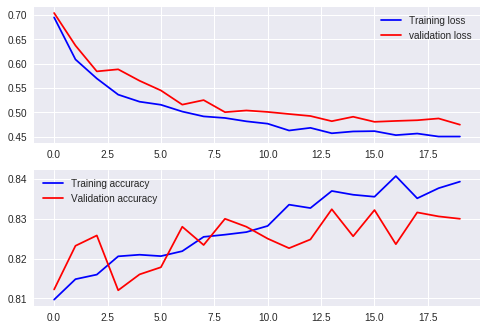

In [0]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [0]:
pred = model.predict(X_val)
Y_pred = np.argmax(pred,axis=1)
print(metrics.accuracy_score(np.argmax(Y_val,axis=1),Y_pred))
print(metrics.f1_score(np.argmax(Y_val,axis=1),Y_pred))
print(metrics.confusion_matrix(np.argmax(Y_val,axis=1),Y_pred))
print(metrics.log_loss(np.argmax(Y_val,axis=1),pre[:,Y_pred]))

0.765
0.7381323824381548
[[2169  362]
 [ 813 1656]]


In [0]:
model.save('nn12.h5')

In [0]:
input_= Input((50,50,1))
conv1  = Conv2D(96,11,padding='same',kernel_regularizer = regularizers.l2(1e-2),activation='relu')(input_)
pool1 = AveragePooling2D((3,3),2)(conv1)
norm1 = BatchNormalization()(pool1)
conv2  = Conv2D(256,5,padding='same',kernel_regularizer = regularizers.l2(1e-2),activation='relu')(norm1)
pool2 =  AveragePooling2D((3,3),2)(conv2)
norm2 = BatchNormalization()(pool2)
conv3  = Conv2D(384,3,padding='same',activation='relu')(norm2)
conv4  = Conv2D(384,3,padding='same',activation='relu')(conv3)
conv5  = Conv2D(256,3,padding='same',kernel_regularizer = regularizers.l2(1e-2),activation='relu')(conv4)
pool6 =  AveragePooling2D((3,3),2)(conv5)
flat7 = Flatten()(pool6)
drop8 = Dropout(0.5)(flat7)
dense9 = Dense(128,kernel_regularizer = regularizers.l2(1e-2),activation='relu')(drop8)
dense10 = Dense(128,activation='relu')(dense9)
dense11 = Dense(2,activation='softmax')(dense10)

model1 = Model(inputs=input_,outputs=dense11)
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 50, 50, 1)         0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 50, 50, 96)        11712     
_________________________________________________________________
average_pooling2d_7 (Average (None, 24, 24, 96)        0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 24, 24, 96)        384       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 24, 24, 256)       614656    
_________________________________________________________________
average_pooling2d_8 (Average (None, 11, 11, 256)       0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 11, 11, 256)       1024      
__________

In [0]:
sgd = optimizers.SGD(lr = 0.01, momentum = 0.9, nesterov = True)
model1.compile(optimizer=sgd,loss='binary_crossentropy',metrics=['accuracy'])

In [0]:
history1 = model1.fit(X_train,Y_train,epochs=20,batch_size=100,validation_data=(X_val,Y_val),callbacks=[lr_reduce])

Train on 20000 samples, validate on 5000 samples
Epoch 1/20
20000/20000 [==============================] - 31s 2ms/step - loss: 5.6325 - acc: 0.5802 - val_loss: 3.8774 - val_acc: 0.6068
Epoch 2/20
20000/20000 [==============================] - 29s 1ms/step - loss: 2.8617 - acc: 0.6219 - val_loss: 2.0840 - val_acc: 0.6178
Epoch 3/20
20000/20000 [==============================] - 29s 1ms/step - loss: 1.6237 - acc: 0.6435 - val_loss: 1.2618 - val_acc: 0.6596
Epoch 4/20
20000/20000 [==============================] - 29s 1ms/step - loss: 1.0700 - acc: 0.6634 - val_loss: 0.9305 - val_acc: 0.6446
Epoch 5/20
20000/20000 [==============================] - 29s 1ms/step - loss: 0.8201 - acc: 0.6750 - val_loss: 0.7353 - val_acc: 0.6888
Epoch 6/20
20000/20000 [==============================] - 29s 1ms/step - loss: 0.7032 - acc: 0.6886 - val_loss: 0.6864 - val_acc: 0.6736
Epoch 7/20
20000/20000 [==============================] - 29s 1ms/step - loss: 0.6412 - acc: 0.7058 - val_loss: 0.6805 - val_acc:

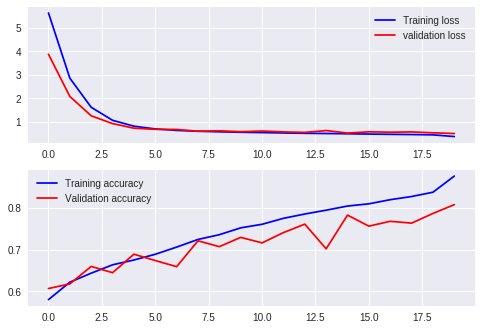

In [0]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history1.history['loss'], color='b', label="Training loss")
ax[0].plot(history1.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history1.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history1.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [0]:
pred = model1.predict(X_val)
Y_pred = np.argmax(pred,axis=1)
print(metrics.accuracy_score(np.argmax(Y_val,axis=1),Y_pred))
print(metrics.f1_score(np.argmax(Y_val,axis=1),Y_pred))
print(metrics.confusion_matrix(np.argmax(Y_val,axis=1),Y_pred))
print(metrics.log_loss(np.argmax(Y_val,axis=1),pre[:,Y_pred]))

0.8072
0.7997507270461155
[[2111  420]
 [ 544 1925]]


In [0]:
model1.save('nn21.h5')

In [0]:
train_datagen.fit(X_train)
val_datagen.fit(X_val)
train_generator = train_datagen.flow(X_train,Y_train,batch_size=100)
val_generator = val_datagen.flow(X_val,Y_val,batch_size=100)

In [0]:
history1 = model1.fit_generator(train_generator,validation_data=val_generator,steps_per_epoch = X_train.shape[0]/100,validation_steps=X_val.shape[0]/100, epochs=20,callbacks=[lr_reduce])

Epoch 1/20
200/200 [==============================] - 29s 147ms/step - loss: 0.5441 - acc: 0.7803 - val_loss: 0.5133 - val_acc: 0.7958
Epoch 2/20
200/200 [==============================] - 29s 146ms/step - loss: 0.5324 - acc: 0.7795 - val_loss: 0.5027 - val_acc: 0.7988
Epoch 3/20
200/200 [==============================] - 29s 146ms/step - loss: 0.5199 - acc: 0.7880 - val_loss: 0.4924 - val_acc: 0.8024
Epoch 4/20
200/200 [==============================] - 29s 146ms/step - loss: 0.5128 - acc: 0.7912 - val_loss: 0.4913 - val_acc: 0.8064
Epoch 5/20
200/200 [==============================] - 29s 146ms/step - loss: 0.5064 - acc: 0.7944 - val_loss: 0.4882 - val_acc: 0.7982
Epoch 6/20
200/200 [==============================] - 29s 146ms/step - loss: 0.5027 - acc: 0.7912 - val_loss: 0.4907 - val_acc: 0.7988
Epoch 7/20
200/200 [==============================] - 29s 147ms/step - loss: 0.4937 - acc: 0.7961 - val_loss: 0.4797 - val_acc: 0.8088
Epoch 8/20
200/200 [==============================] - 2

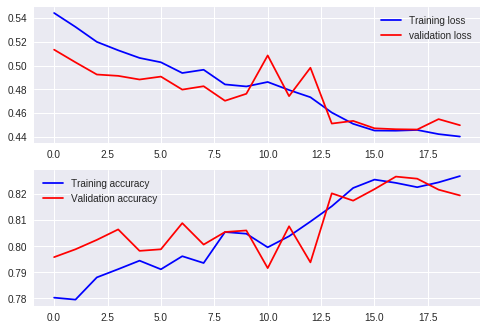

In [0]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history1.history['loss'], color='b', label="Training loss")
ax[0].plot(history1.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history1.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history1.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [0]:
pred = model1.predict(X_val)
Y_pred = np.argmax(pred,axis=1)
print(metrics.accuracy_score(np.argmax(Y_val,axis=1),Y_pred))
print(metrics.f1_score(np.argmax(Y_val,axis=1),Y_pred))
print(metrics.confusion_matrix(np.argmax(Y_val,axis=1),Y_pred))
print(metrics.log_loss(np.argmax(Y_val,axis=1),pre[:,Y_pred]))

0.7652
0.746545768566494
[[2097  434]
 [ 740 1729]]


In [0]:
model1.save('nn22.h5')

In [0]:
import pandas as pd
model.load_weights('nn11.h5')

In [0]:
pre = model1.predict(X_test)
Y_pre = np.argmax(pre,axis=1)

dog [0.01603641 0.98396355] 0


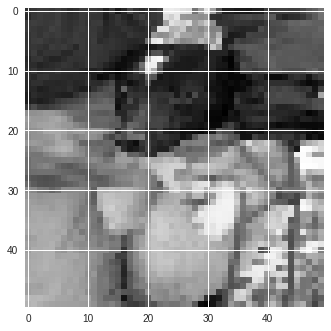

dog [0.01166851 0.9883315 ] 1


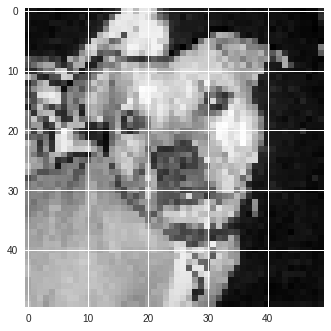

dog [0.23126507 0.76873493] 2


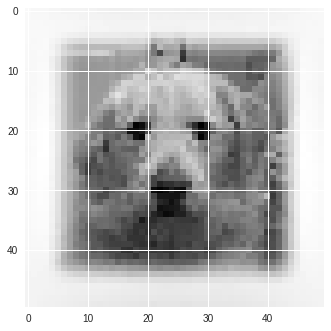

dog [0.21530639 0.78469354] 3


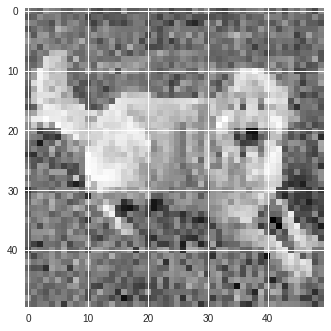

dog [0.11015755 0.88984245] 4


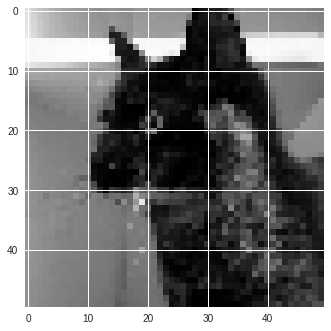

dog [0.06288255 0.93711746] 5


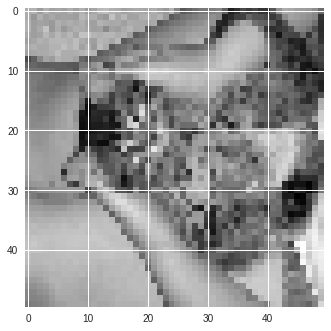

cat [0.9760123  0.02398769] 6


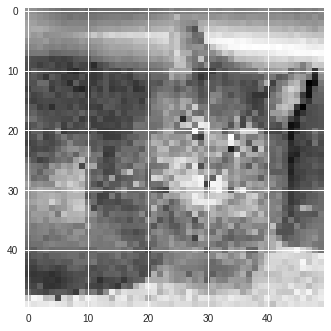

dog [0.3435158  0.65648425] 7


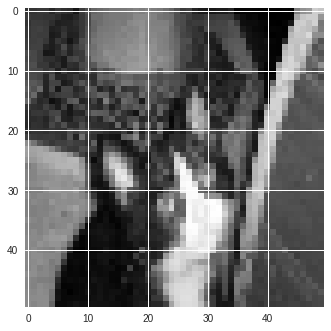

cat [0.9881563  0.01184371] 8


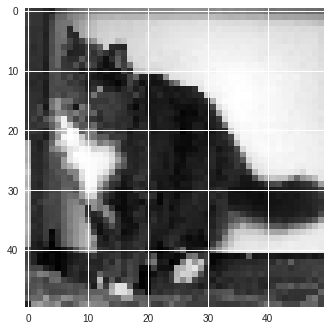

cat [0.99334407 0.00665592] 9


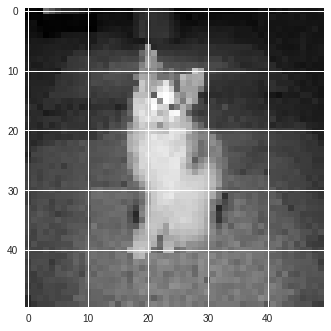

cat [0.9904275  0.00957249] 10


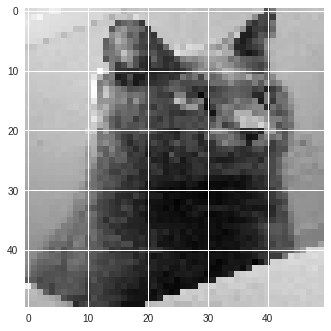

dog [0.13249557 0.8675044 ] 11


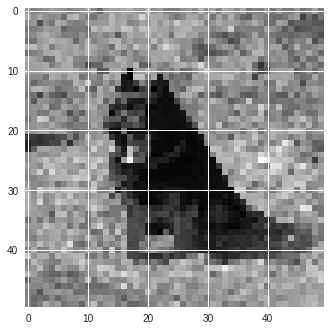

cat [0.9914957 0.0085043] 12


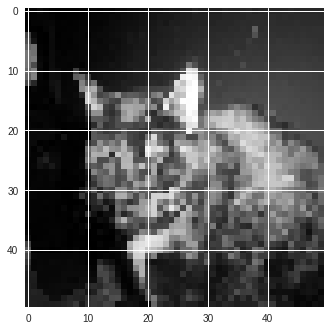

cat [0.99569964 0.00430037] 13


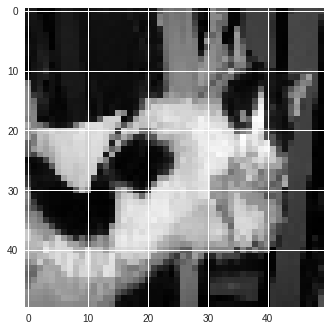

cat [0.9947812  0.00521883] 14


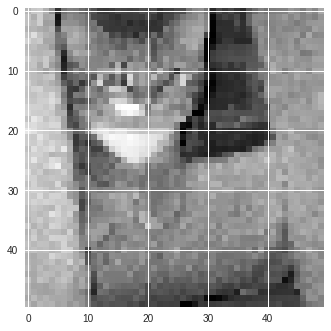

dog [0.39820093 0.601799  ] 15


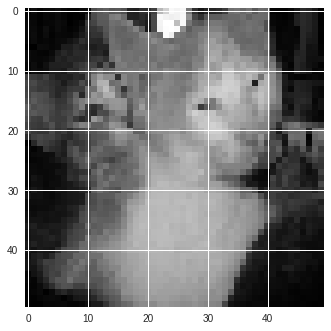

dog [0.31161398 0.6883861 ] 16


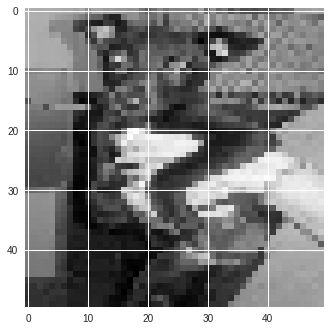

cat [0.8872887  0.11271138] 17


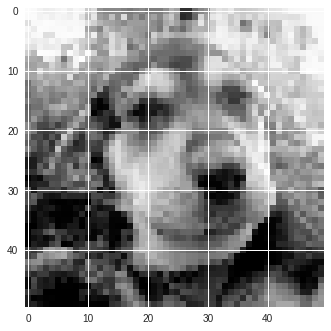

dog [0.14490075 0.8550992 ] 18


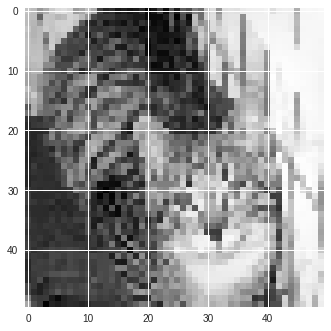

cat [0.996644   0.00335605] 19


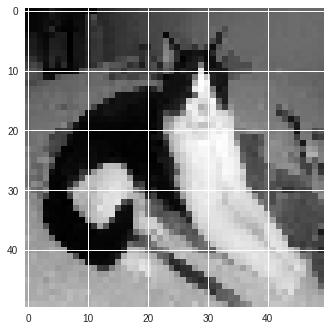

dog [0.00457127 0.9954287 ] 20


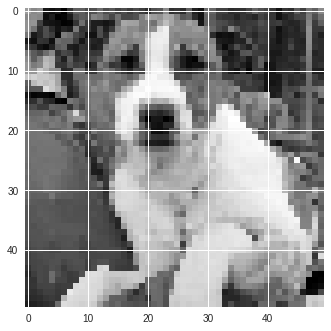

cat [0.9970523  0.00294772] 21


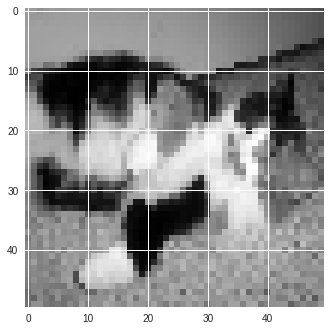

dog [0.00684337 0.9931566 ] 22


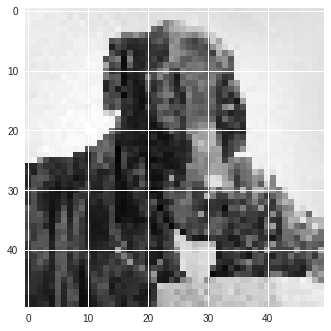

dog [0.19149691 0.80850315] 23


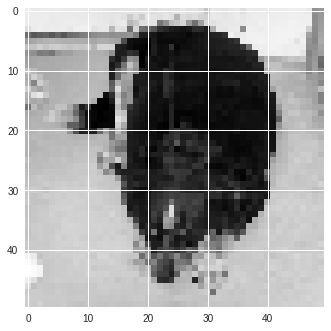

cat [0.8674088  0.13259125] 24


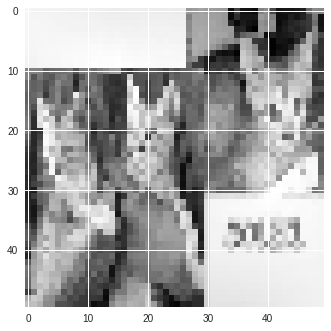

dog [0.01887648 0.9811235 ] 25


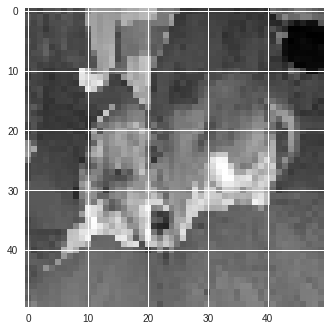

cat [0.77741325 0.22258675] 26


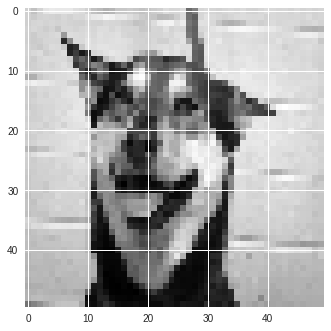

cat [0.9961826  0.00381739] 27


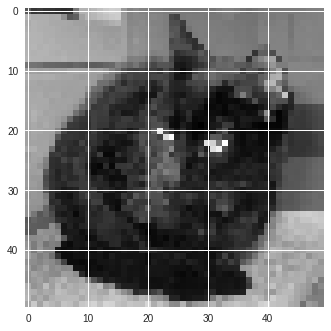

dog [0.35762176 0.6423782 ] 28


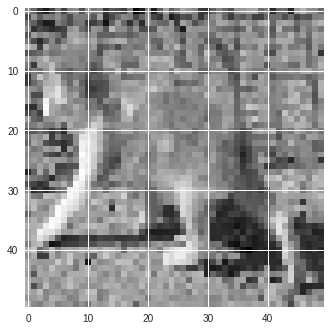

cat [0.5794382  0.42056182] 29


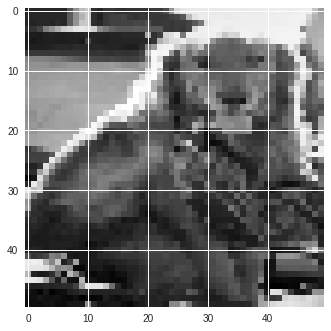

dog [0.02533115 0.9746688 ] 30


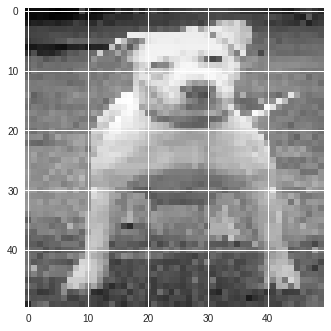

dog [0.13026537 0.86973464] 31


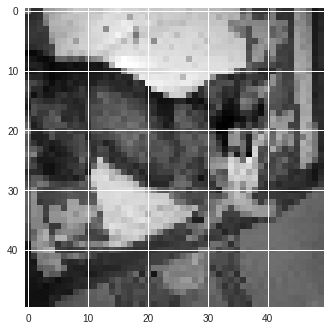

dog [0.31062475 0.6893753 ] 32


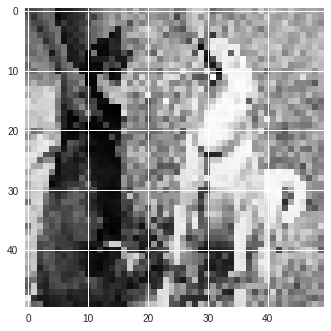

cat [0.92010546 0.07989451] 33


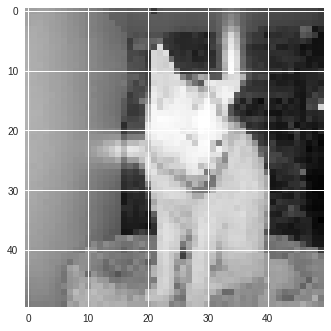

dog [0.42459792 0.5754021 ] 34


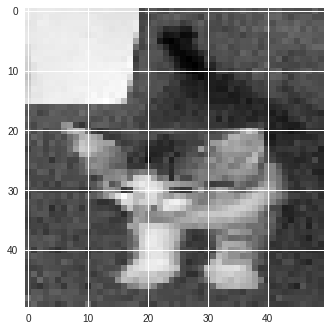

cat [0.9917482  0.00825175] 35


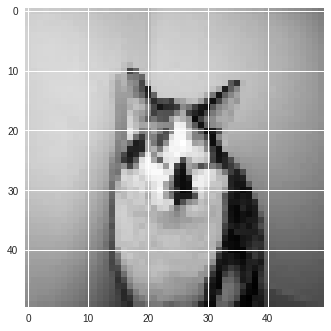

cat [0.9944127  0.00558736] 36


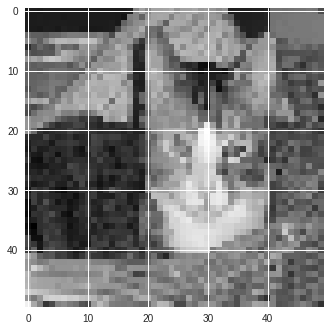

cat [0.9683858  0.03161421] 37


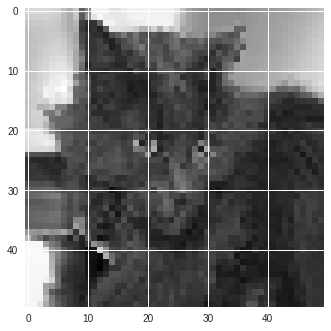

cat [0.5074335  0.49256653] 38


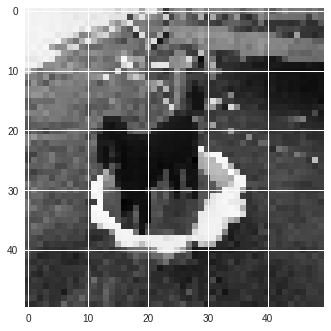

cat [0.89409035 0.10590965] 39


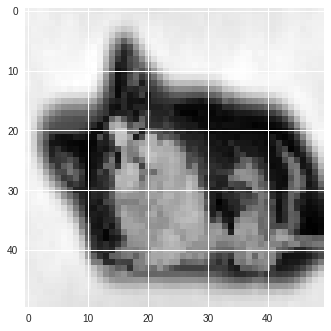

dog [0.347611 0.652389] 40


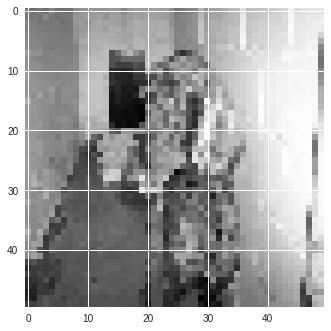

dog [0.01561197 0.984388  ] 41


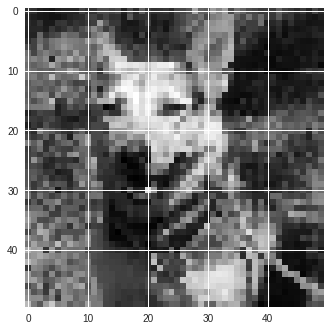

dog [0.00661339 0.9933867 ] 42


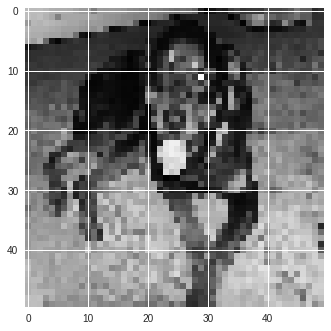

dog [0.17152964 0.82847035] 43


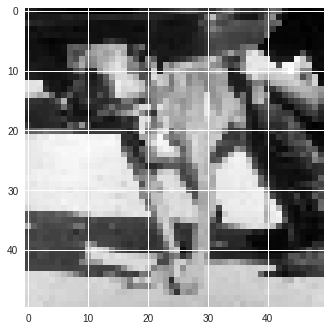

cat [0.57522917 0.42477083] 44


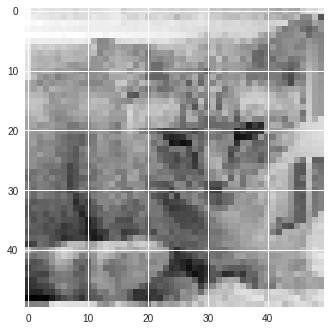

dog [0.00480937 0.9951906 ] 45


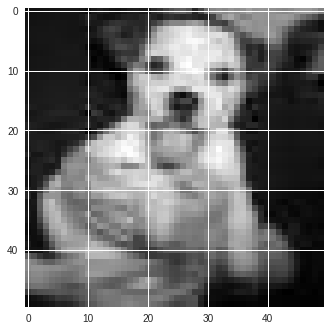

dog [0.2750965 0.7249035] 46


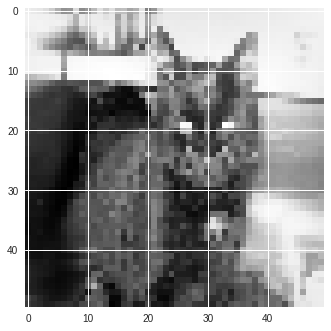

dog [0.21032423 0.7896758 ] 47


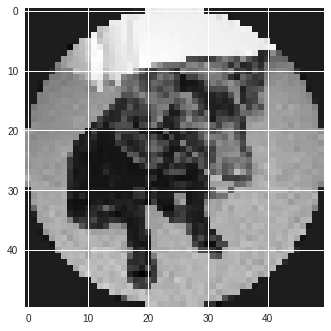

dog [0.01278697 0.9872131 ] 48


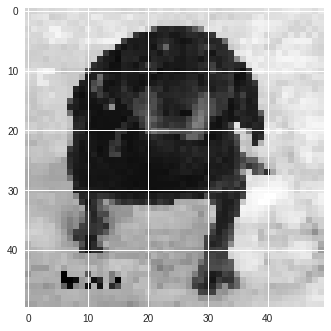

cat [0.99442875 0.00557121] 49


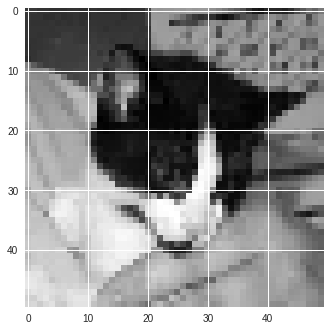

cat [0.99441344 0.00558657] 50


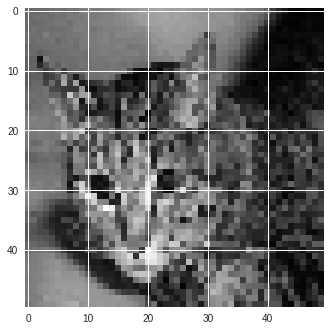

cat [0.97186714 0.02813288] 51


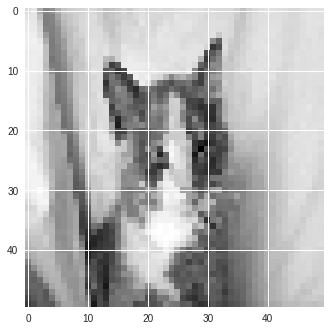

cat [0.8986829  0.10131709] 52


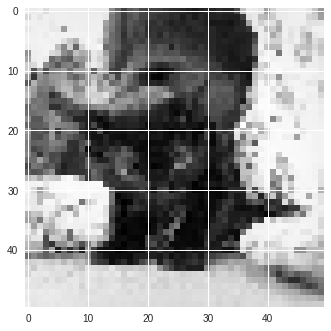

cat [0.9967368  0.00326311] 53


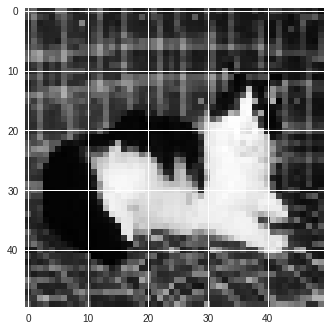

dog [0.06955698 0.930443  ] 54


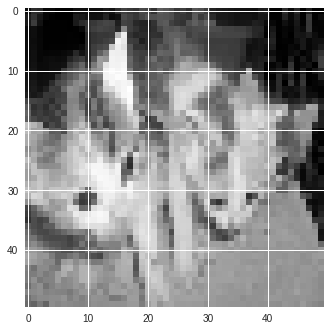

In [0]:
for i in range(55):
  plt.imshow(X_test[i].reshape(50,50),cmap='gray')
  print(mapping_label[Y_pre[i]],pre[i],i)
  plt.show()

In [0]:
sample = pd.read_csv('./sampleSubmission.csv')

,id,label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [0]:
sample.to_csv('Y_pre.csv',sep=',',index=False)

In [0]:
pre = pd.read_csv('Y_pre.csv') 
pre.head()

,id,label
0,1,1
1,2,1
2,3,1
3,4,1
4,5,1


In [0]:
model1.load_weights('nn21.h5')